## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df["converted"].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0]

1965

In [7]:
df.query("group == 'control' and landing_page != 'old_page'").shape[0]

1928

In [8]:
#sum of both mismatches where the treatment isn't the new page and the control isn't the old page
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0] + df.query("group == 'control' and landing_page != 'old_page'").shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Well, it seems that there are no null values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
#we will make a new dataser with all the mismatched rows
df_mismatch1 = df.query("group == 'control' and landing_page != 'old_page'")
df_mismatch2 = df.query ("group == 'treatment' and landing_page != 'new_page'")
total_mismatch = df_mismatch1.append(df_mismatch2)


In [11]:
#now we will create a new dataser called df2 with the mismatched rows dropped
df2 = df.drop(total_mismatch.index, axis=0)


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
#the duplicated user id
duplicate_id = df2.loc[ df2.user_id.duplicated(), "user_id"]
duplicate_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
#showing the whole row of that duplicated id
duplicated_row = df2.loc[df2.user_id.duplicated()]
duplicated_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.shape[0]

290585

In [17]:
# I have indexed the row that is duplicated, then dropped it
duplicated_row_index = df2.loc[df2.user_id.duplicated()].index
df2 = df2.drop(duplicated_row_index)


In [18]:
# Check again if the row with a duplicate user_id is deleted or not
df2.shape[0]

290584

The number of rows became 290584 instead of 290584    
That means we have dropped the row with repeated id successfully.

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
p_population = df2["converted"].mean()
p_population

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
#calculating the probability of being converted given the person in the control group
p_converted_given_control = df2.query("group == 'control' and converted == 1").shape[0]/ df2.query("group == 'control'").shape[0]
p_converted_given_control


0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
#calculating the probability of being converted given the person in the treatment group
p_converted_given_treatment = df2.query("group == 'treatment' and converted == 1").shape[0]/ df2.query("group == 'treatment'").shape[0]
p_converted_given_treatment


0.11880806551510564

In [22]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff =  p_converted_given_treatment - p_converted_given_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [23]:
probability_newpage = df2.query("landing_page == 'new_page'").shape[0]/df2.shape[0]
probability_newpage

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**   
### notes and explaination
From the results above, it is obvious that the probability of conversion having the user in the control group was bigger than that where the person in the treatment group.   
The difference between both conversions was calculated as obs_diff (treatment - control)  and it was -0.0015.   
So, we can say that the new page is not better than the old one.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
The hypothesis will be:    
H0 : pnew - pold <= 0   
H1 : pnew- pold > 0   
So, we are assuming that the null hypothesis (ie; the new page is no better or even worse) is true. And we will work on the alternative hypothesis with the p-value to see if we can reject the null or not.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
pnew = df2.query("converted == 1").shape[0]/df2.shape[0]
pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
pold = df2.query("converted == 1").shape[0]/df2.shape[0]
pold

0.11959708724499628

That seems logic, as we assumed before that the conversion rates from both the old page and the new one are equal.

c. What is $n_{new}$?

In [26]:
nnew = df2.query("group == 'treatment'").shape[0]
nnew

145310

d. What is $n_{old}$?

In [27]:
nold = df2.query("group == 'control'").shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([0,1], size=nnew,p= [(1-pnew), pnew] )
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1], size=nold,p= [(1-pold), pold] )
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

In [30]:
pn = new_page_converted.mean()
pn

0.12051476154428463

In [31]:
po = old_page_converted.mean()
po

0.12039318804466044

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
difference = pn - po
difference

0.00012157349962418906

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [35]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([0,1], size=nnew,p= [(1-pnew), pnew] )
    old_page_converted = np.random.choice([0,1], size=nold,p= [(1-pold), pold] )
    p_diff = (new_page_converted.mean()) - (old_page_converted.mean())
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [36]:
p_diffs = np.array(p_diffs)

In [37]:
p_diffs.std()

0.001200847741528369

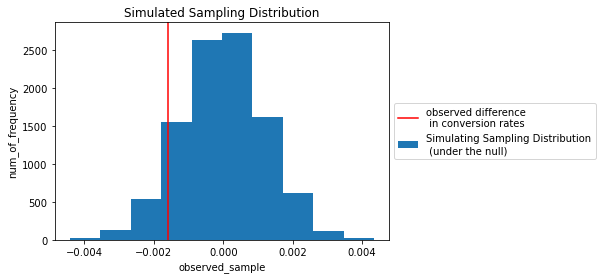

In [39]:
plt.hist(p_diffs, label = "Simulating Sampling Distribution\n (under the null)");
plt.axvline(x=obs_diff, color="red", label= "observed difference\n in conversion rates");
plt.title("Simulated Sampling Distribution");
plt.xlabel("observed_sample");
plt.ylabel("num_of_frequency");
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5));

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [40]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

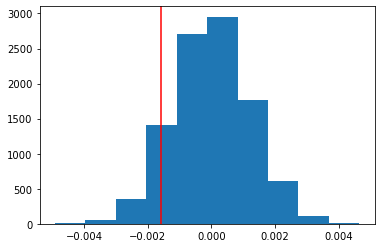

In [41]:
# plot null distribution
plt.hist(null_vals)

# plot line for observed statistic
plt.axvline(obs_diff, c='red')

In [42]:
# compute p value
(null_vals > obs_diff).mean()

0.9084

The p-value is 0.9061

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**   
This value that I have calculated  is the p-value.    
I used one-tailed test here according to the hypothesis I have set before.   
As shown above, after calculating the p-value, it equals 0.9061. So, if we assume to have an alpha value(percentage of type 1 error) of 0.05, this p-value is greater than the alpha. It means that these results could  have happenned by chance and they are not statitistically  significant. So we fail to reject the null hypothesis, ie; the new page is not better than the old one.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [43]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [44]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = "larger")
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [45]:
convert_old, n_old

(17489, 145274)

In [46]:
convert_new, n_new

(17264, 145310)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**   
After calculating the z-score and the p-value above. The p-value has nearly the same value calculated before. So the result is the same.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**   
I will choose the [Logistic Regression] because there only two values.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [47]:
#just to remember the columns' names and values inside
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [48]:
df2["intercept"] = 1
df2[["control", "ab_page"]] = pd.get_dummies(df2["group"])
df2 = df2.drop("control", axis =1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [50]:
logit_mod = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [51]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Jan 2022   Pseudo R-squ.:               8.077e-06
Time:                        21:42:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [52]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [53]:
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

From the results above we can conslude that: The person will be 1.015 more likely to convert if he is in the treatment group.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**    
The p-value here in this Logistic Regression Model = 0.190 (bigger than 0.05) which denotes that it is not statistically significant and we fail to reject the null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**   
Sometimes we need more than the lower terms. That happens when there is relationship between the explanatory variables and one another.    
For example, if the slope of a line representing the relation between x1 and y is the same as the line of x2 and y, then we won't need higher term models.   
But if the slope isn't the same, then we might need to have higher terms eg; interactions, quadratics, cubics.....etc.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [54]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [55]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [56]:
# I want to know the names  and the number of countries
df_new["country"].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

So, we have three unique countries which are US, UK and CA.

In [57]:
### Create the necessary dummy variables
df_new[["US", "UK", "CA"]] = pd.get_dummies(df_new["country"])
df_new= df_new.drop("CA", axis =1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [58]:
### Fit Your Linear Model And Obtain the Results
logit_mod2 = sm.Logit(df_new["converted"], df_new[["intercept", "ab_page", "US", "UK"]])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Jan 2022   Pseudo R-squ.:               2.323e-05
Time:                        21:43:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [59]:
np.exp(results2.params)

intercept    0.136795
ab_page      0.985168
US           0.960062
UK           1.009932
dtype: float64

Also, we can see that the coeff of US is below 1, so we calculate the reciprocal.

In [60]:
1/np.exp(results2.params)

intercept    7.310207
ab_page      1.015056
US           1.041599
UK           0.990165
dtype: float64

### Interpretation of the results   
we can see that the p-value for US and Uk are 0.13 and 0.457 which are  bigger than the 0.05 , so they are  not statistically significant.    
From the results of the coeff above, we can say that if the person is from US he is 1.04 more likely to convert than the person from CA (holding all other variables are constant).

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [61]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [62]:
#using higher order terms
#I will make new variables by multiplying
df_new['US_inter'] = df_new['US']*df_new['ab_page']
df_new['UK_inter'] = df_new['UK']*df_new['ab_page']

In [63]:
#now we will create a new model using these higher order terms
logit_mod3 = sm.Logit(df_new["converted"], df_new[["intercept", "ab_page", "US", "UK", "US_inter", "UK_inter"]])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 28 Jan 2022   Pseudo R-squ.:               3.482e-05
Time:                        22:27:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_inter      -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_inter       0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [64]:
np.exp(results3.params)

intercept    0.137178
ab_page      0.979646
US           0.982625
UK           0.994272
US_inter     0.954198
UK_inter     1.031896
dtype: float64

In [65]:
#as the coeff is below 1, we will calculate the reciprocal.
1/np.exp(results3.params)

intercept    7.289813
ab_page      1.020776
US           1.017682
UK           1.005761
US_inter     1.048001
UK_inter     0.969090
dtype: float64

### interpretation of the results   
After using higher order terms in our model, it is not easy to interpret the results of them any more. Yet, we can still interpret the results of the lower terms. If the person is from US, it is 1.017 less likely to be converted than if he is from CA.   
If the person is from UK, it is 1.005 less likely to be converted than if he is from CA.   


## Final conclusion   
we have tested the benefit of using a new web page in terms of "conversion" in three different ways;    
1) we have used the probability    
2) we have used the hypothesis testing   
3) we have used the logistic regression models   
   
   From probabilty, the results were not statistically significant and we could not say that the new page is better than the old one.   
   
   From the hypothesis testing, the p-value calculated was not lower than the alph (type 1 erroe percentage), so we could not reject the null hypothesis which denotes that the new page is not  better or even worse than the old page.   
   
   From the regression models, we got nearly the same value of the p-value, so the interpretaion remains the same.


<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

###Resources    
www.stackoverflow.com